In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook", "grid"])

In [3]:
import sys

In [4]:
sys.path.append('./emdp')

In [5]:
%config Completer.use_jedi = False

In [6]:
sys.path

['/Users/swagatam/Desktop/misc/rl',
 '/usr/local/Cellar/python@3.8/3.8.9/Frameworks/Python.framework/Versions/3.8/lib/python38.zip',
 '/usr/local/Cellar/python@3.8/3.8.9/Frameworks/Python.framework/Versions/3.8/lib/python3.8',
 '/usr/local/Cellar/python@3.8/3.8.9/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload',
 '',
 '/Users/swagatam/Library/Python/3.8/lib/python/site-packages',
 '/usr/local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/site-packages/IPython/extensions',
 '/Users/swagatam/.ipython',
 './emdp']

### Exploring gridworld code from this repo: https://github.com/zafarali/emdp

In [24]:
import emdp.gridworld as gw
from emdp.gridworld import build_simple_grid
from emdp.gridworld.builder_tools import create_reward_matrix
from emdp import actions
from emdp.gridworld import GridWorldPlotter
from emdp.analytic import calculate_V_pi

In [8]:
def build_SB_example41():
    
    """
    There are four actions possible in each state, A = {up, down, right, left}, which deterministically cause the
    corresponding state transitions, except that actions that would take the agent off the grid in fact leave the
    state unchanged.
    This is an undiscounted, episodic task. 
    The reward is -1 on all transitions until the terminal state is reached.
    The terminal state is shaded in the figure (although it is shown in two places, it is formally one state).
    """
    size = 4
    gamma = 1      # undiscounted episodic task
    p_success = 1  # actions always successful
    
    
    reward_spec = {(0, 0): 0, (size-1, size-1): 0}
    
    P = build_simple_grid(size=size, terminal_states=reward_spec.keys(), p_success=p_success)
    R = create_reward_matrix(P.shape[0], size, reward_spec, action_space=4)
    R += -1        # set all transitions to -1 as create_reward_matrix initializes to 0
    R[0, :] = 0
    R[15, :] = 0
    R[16, :] = 0   # also set the created absorbing state's reward to 0
    #print(R)
    
    # note: terminal/absorbing states can't be the starting state!
    num_terminal_states = len(reward_spec.keys()) + 1  # add 1 for constructed absorbing state
    p0 = np.ones(P.shape[0])
    p0[0] = 0
    p0[15] = 0
    p0[16] = 0
    p0 = p0/(P.shape[0]-num_terminal_states)  # uniform starting probability (assumed)
    
    return gw.GridWorldMDP(P, R, gamma, p0, terminal_states=reward_spec.keys(), size=size)

In [9]:
mdp = build_SB_example41()
# state, reward, done, _ = mdp.step(actions.UP) # moves the agent up.

In [10]:
mdp.terminal_states, mdp.current_state, mdp.human_state, mdp.gamma, mdp.done, mdp.has_absorbing_state

([0, 15],
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (1, 0),
 1,
 False,
 True)

In [11]:
# current_state = one hot representation of state vector
# human_state = (x, y) coordinate of current_state of the agent!

In [12]:
mdp.p0

array([0.        , 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.        , 0.        ])

In [13]:
mdp.P.shape

(17, 4, 17)

In [14]:
# def build_SB_example35():
#     """
#     Example 3.5 from (Sutton and Barto, 2018) pg 60 (March 2018 version).
#     A rectangular Gridworld representation of size 5 x 5.

#     Quotation from book:
#     At each state, four actions are possible: north, south, east, and west, which deterministically
#     cause the agent to move one cell in the respective direction on the grid. Actions that
#     would take the agent off the grid leave its location unchanged, but also result in a reward
#     of −1. Other actions result in a reward of 0, except those that move the agent out of the
#     special states A and B. From state A, all four actions yield a reward of +10 and take the
#     agent to A'. From state B, all actions yield a reward of +5 and take the agent to B'
#     """
#     size = 5
#     P = gw.build_simple_grid(size=size, p_success=1)
#     # modify P to match dynamics from book.

#     P[1, :, :] = 0 # first set the probability of all actions from state 1 to zero
#     P[1, :, 21] = 1 # now set the probability of going from 1 to 21 with prob 1 for all actions

#     P[3, :, :] = 0  # first set the probability of all actions from state 3 to zero
#     P[3, :, 13] = 1  # now set the probability of going from 3 to 13 with prob 1 for all actions

#     R = np.zeros((P.shape[0], P.shape[1])) # initialize a matrix of size |S|x|A|
#     R[1, :] = +10
#     R[3, :] = +1

#     p0 = np.ones(P.shape[0])/P.shape[0] # uniform starting probability (assumed)
#     gamma = 0.9

#     terminal_states = []
#     return gw.GridWorldMDP(P, R, gamma, p0, terminal_states, size)

In [15]:
# mdp = build_SB_example35()
# state, reward, done, _ = mdp.step(actions.UP) # moves the agent up.

## build and simulate a sample trajectory

In [16]:
mdp = build_SB_example41()
mdp.terminal_states, mdp.gamma, mdp.human_state, mdp.done, mdp.has_absorbing_state

([0, 15], 1, (2, 2), False, True)

In [17]:
gwp = GridWorldPlotter(mdp.size, mdp.has_absorbing_state) # alternatively you can use GridWorldPlotter.from_mdp(mdp)

# collect/sample some trajectories from the GridWorldMDP object:

trajectories = []
for _ in range(1): # 3 trajectories
#     trajectory = [mdp.reset()]
    trajectory = [mdp.current_state]
    for _ in range(100): # 10 steps maximum
        state, reward, done, info = mdp.step(random.sample([actions.LEFT, actions.RIGHT, 
                                                        actions.UP, actions.DOWN], 1)[0])
        trajectory.append(state)
        if done:
            trajectory= trajectory[:-1] # whichever terminal state it hits, it moves to (0, 0). so remove last
            break
    trajectories.append(trajectory)

In [18]:
trajectories[0]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

<AxesSubplot:xlabel='x', ylabel='y'>

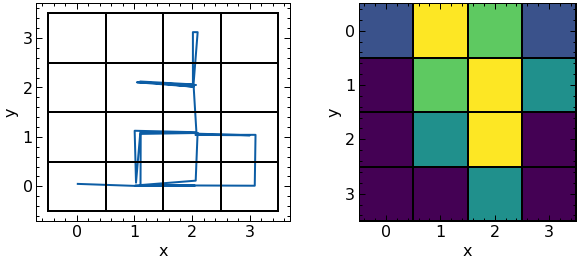

In [19]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)

# trajectory
gwp.plot_trajectories(ax, trajectories)
gwp.plot_grid(ax)

# heatmap
ax = fig.add_subplot(122)
gwp.plot_heatmap(ax, trajectories)
gwp.plot_grid(ax)

## test $V_\pi$ solution for $\pi$ = equiprobable random policy

In [20]:
# random policy:
policy = np.ones((mdp.P.shape[0], mdp.P.shape[1]))/mdp.P.shape[1]

In [23]:
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

use analytic solution provided.
make sure to **remove** the added absorbing state i.e., take only the original (size x size) states

In [40]:
V_pi = calculate_V_pi(mdp.P[:-1, ..., :-1], mdp.R[:-1, ...], policy[:-1, ...], mdp.gamma)

In [41]:
V_pi.reshape(mdp.P.shape[1], mdp.P.shape[1])

array([[  0., -14., -20., -22.],
       [-14., -18., -20., -20.],
       [-20., -20., -18., -14.],
       [-22., -20., -14.,   0.]])

In [42]:
mdp.P[:-1, ..., :-1].shape

(16, 4, 16)